<a href="https://colab.research.google.com/github/byambaa1982/lstm_model/blob/master/brunobuger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
# !pip install --upgrade tensorflow

In [2]:
df=pd.read_csv('/content/backtest_model_v2.csv')
df["status"]=df["status"].map(lambda x:1 if x=='GAIN' else 0)
df["shortlong"]=df["shortlong"].map(lambda x:1 if x=='VENDIDO' else 0)
df.head()

,status,shortlong,forceIndex,trend2min,trend5min,trend10min,trend15min,buildDate
0,1,1,195,50,-10,-145,0,1564661040000
1,1,0,95,-15,-40,55,100,1564661940000
2,0,0,145,20,130,170,200,1564662840000
3,1,0,85,15,-10,50,70,1564665540000
4,1,0,95,90,55,100,125,1564665840000


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [4]:
uni_data = df['trend2min']
uni_data.index = df['buildDate']
uni_data.head()

buildDate
1564661040000    50
1564661940000   -15
1564662840000    20
1564665540000    15
1564665840000    90
Name: trend2min, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1dccb320f0>],
      dtype=object)

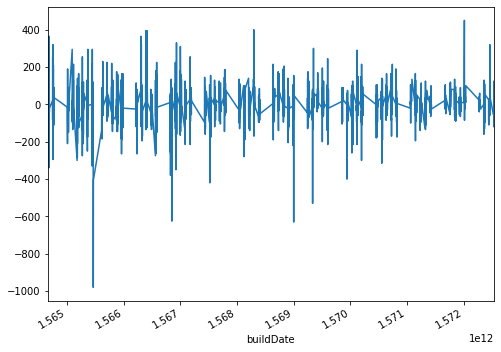

In [5]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [0]:
TRAIN_SPLIT = 1000

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [11]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[ 0.56986556]
 [-0.07101998]
 [ 0.27407224]
 [ 0.22477335]
 [ 0.96425667]
 [ 0.66846334]
 [ 0.66846334]
 [-0.41611219]
 [ 0.47126779]
 [ 0.4219689 ]
 [ 0.47126779]
 [-0.41611219]
 [-0.16961775]
 [ 0.91495778]
 [ 0.37267001]
 [-1.35279106]
 [ 0.12617557]
 [ 0.4219689 ]
 [-0.31751442]
 [-0.21891664]]

 Target temperature to predict
1.0628544436459573


In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

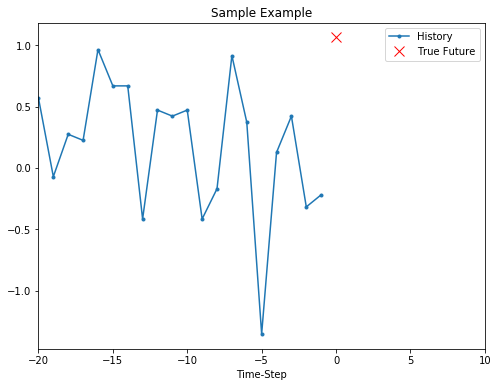

In [14]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

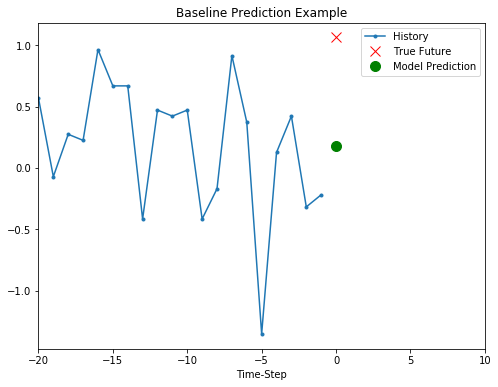

In [16]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [19]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [20]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 25ms/step - loss: 0.6790 - val_loss: 0.5181
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6770 - val_loss: 0.5188
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6746 - val_loss: 0.5211
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6694 - val_loss: 0.5272
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6666 - val_loss: 0.5289
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6636 - val_loss: 0.5289
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6617 - val_loss: 0.5296
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6596 - val_loss: 0.5314
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6579 - val_loss: 0.5329
Epoch 10/10
200/200 [===========================

# Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

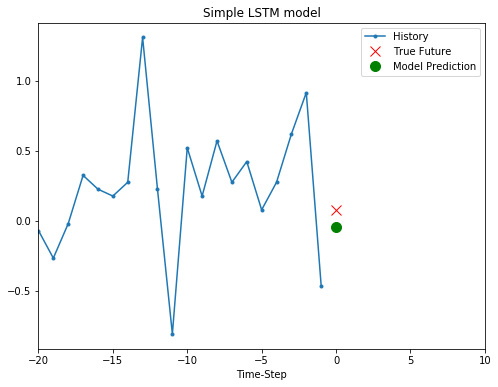

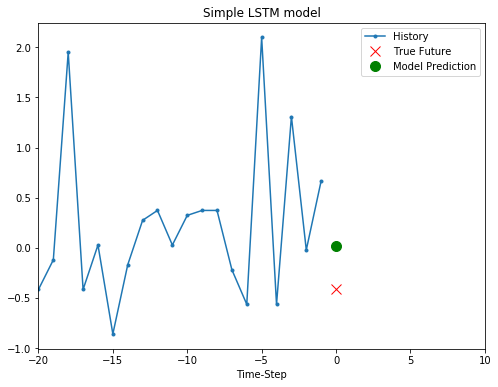

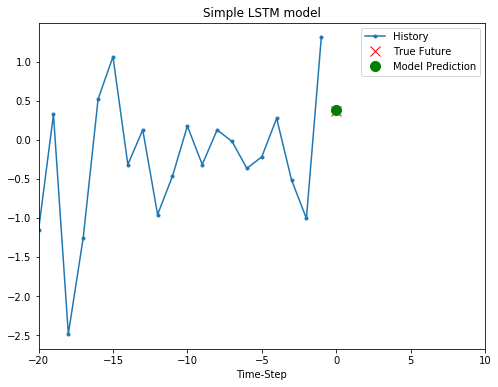

In [21]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# Part 2: Forecast a multivariate time series